# Custom model training for gesture recognition

Import the required libraries

In [31]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Load the list of gesture form the `gesture_list.csv` file

In [32]:
# Define which gestures should be detected by the model
gesture_list = np.loadtxt("gesture_list.csv", delimiter=',', dtype=str)
print(gesture_list)
num_gestures = len(gesture_list)

['none' 'open' 'fist' 'index' 'L']


Load the dataset from the file

In [33]:

dataset_filepath = "dataset.csv"
handedness = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.str_, usecols=(0))
y_data_labels = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.str_, usecols=(1))
x_data = np.loadtxt(dataset_filepath, delimiter=',', dtype=np.float32, usecols=list(range(2, (21*3)+2)))

In [34]:
print(handedness[0])
print(y_data_labels[0])
print(x_data.shape)
print(x_data[0].shape)

Left
open
(1100, 63)
(63,)


In [35]:
unique, counts = np.unique(y_data_labels, return_counts=True)
label_count = dict(zip(unique, counts))
for elem in label_count:
    print(f"{elem}: {label_count[elem]}")

L: 300
fist: 300
index: 300
open: 200


Normalize data: convert to N x 21 x 3 -> normalization -> convert to N x 63

In [36]:
N = x_data.shape[0]
x_data_tensor = np.zeros((N,21,3))
for i in range(N):
    for j in range(21):
        for k in range(3):
            x_data_tensor[i,j,k] = x_data[i, 3*j+k]

assert x_data[200,15] == x_data_tensor[200, 5, 0]

from landmark_normalizer import HandLandmarkNormalizer
hln = HandLandmarkNormalizer()
    
x_data_normalized = np.zeros_like(x_data)
for i, gesture in enumerate(x_data_tensor):
    x_data_normalized[i] = hln(gesture, handedness[i]).reshape(-1)
    
assert x_data_normalized.shape == x_data.shape

x_data = x_data_normalized

Define the ID of each gesture. The ID coincides with the row number in the file

In [37]:
y_data = np.zeros((y_data_labels.shape[0]))
for i, label in enumerate(y_data_labels):
    for j, gesture in enumerate(gesture_list):
        if label == gesture and gesture in gesture_list:
            # "Substitute" the label with the gesture id
            y_data[i] = j

Split the dataset into training and validation sets

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.75)
print(f"Y training set: {y_train}")

Y training set: [3. 4. 2. 4. 2. 3. 3. 4. 1. 1. 1. 1. 2. 3. 4. 3. 1. 4. 3. 1. 4. 2. 3. 2.
 2. 4. 1. 4. 4. 2. 4. 2. 4. 4. 3. 4. 3. 4. 2. 3. 3. 1. 1. 4. 4. 2. 4. 2.
 1. 4. 4. 4. 4. 1. 2. 3. 3. 3. 2. 4. 4. 2. 3. 1. 3. 1. 2. 1. 2. 4. 3. 3.
 4. 2. 1. 2. 2. 4. 3. 4. 4. 1. 2. 2. 2. 3. 3. 4. 4. 4. 2. 4. 2. 4. 3. 1.
 1. 4. 3. 2. 2. 3. 2. 3. 3. 4. 2. 2. 1. 2. 1. 4. 1. 4. 4. 3. 3. 4. 4. 2.
 4. 4. 4. 3. 2. 2. 4. 3. 1. 4. 3. 4. 2. 3. 1. 2. 2. 4. 2. 1. 4. 4. 1. 4.
 3. 1. 4. 2. 2. 4. 1. 4. 2. 3. 2. 4. 3. 2. 2. 2. 3. 4. 4. 2. 3. 3. 3. 3.
 4. 3. 2. 3. 4. 3. 4. 2. 3. 2. 2. 1. 1. 1. 2. 2. 2. 4. 4. 2. 3. 2. 3. 4.
 2. 2. 4. 2. 3. 1. 3. 4. 1. 1. 4. 3. 2. 3. 3. 4. 4. 2. 3. 1. 2. 4. 1. 1.
 3. 3. 3. 2. 4. 2. 1. 3. 4. 4. 2. 1. 4. 1. 3. 1. 3. 4. 2. 1. 3. 2. 2. 2.
 2. 1. 3. 3. 3. 2. 3. 3. 2. 1. 1. 4. 4. 4. 4. 4. 4. 4. 3. 1. 2. 3. 2. 3.
 1. 2. 3. 3. 1. 2. 4. 1. 3. 4. 1. 2. 2. 1. 4. 2. 1. 1. 2. 3. 4. 2. 4. 2.
 2. 2. 4. 2. 2. 2. 2. 3. 2. 3. 4. 4. 1. 1. 2. 3. 4. 3. 3. 1. 3. 3. 4. 3.
 2. 3. 2. 4. 1. 4. 1. 3. 3. 4. 2. 3

Define the model architechture

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(num_gestures, activation='softmax')
])
model.summary()

# Path where to save the model
model_save_path = "model/gesture_classifier.keras"
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 63)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                1280      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1545 (6.04 KB)
Trainable params: 1545 (6.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model

In [40]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Training step

In [41]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/7 [===>..........................] - ETA: 3s - loss: 1.5766 - accuracy: 0.2422
Epoch 1: saving model to model/gesture_classifier.keras
7/7 [==============================] - 1s 29ms/step - loss: 1.5813 - accuracy: 0.2509 - val_loss: 1.5610 - val_accuracy: 0.3127
Epoch 2/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.5505 - accuracy: 0.3047
Epoch 2: saving model to model/gesture_classifier.keras
7/7 [==============================] - 0s 8ms/step - loss: 1.5588 - accuracy: 0.2582 - val_loss: 1.5380 - val_accuracy: 0.3127
Epoch 3/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.5535 - accuracy: 0.2422
Epoch 3: saving model to model/gesture_classifier.keras
7/7 [==============================] - 0s 8ms/step - loss: 1.5354 - accuracy: 0.2594 - val_loss: 1.5175 - val_accuracy: 0.3127
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 1.5312 - accuracy: 0.2266
Epoch 4: saving model to model/gesture_classifier.keras
7/7 [=============

Validation step

In [42]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

3/3 [==============================] - 0s 9ms/step - loss: 0.0856 - accuracy: 0.9855


Save the model with inference optimizations

In [43]:
model.save(model_save_path)

## Confusion matrix

9/9 [==============================] - 0s 786us/step


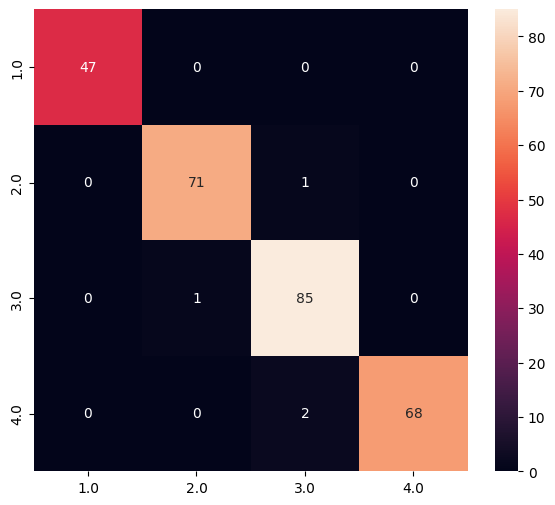

Classification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        47
         2.0       0.99      0.99      0.99        72
         3.0       0.97      0.99      0.98        86
         4.0       1.00      0.97      0.99        70

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [45]:
i = 678
predict_result = model.predict(np.array([x_data[i]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))
print(y_data[i])



1/1 [==============================] - 0s 16ms/step
[8.1073067e-06 1.6096963e-04 1.7284063e-03 8.5721302e-01 1.4088947e-01]
3
3.0
